In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from random import seed
from random import randrange
from sklearn.model_selection import KFold

# Random Forest

In [2]:
def subsample(dataset, n_sample):
    sample = list()
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

In [3]:
def create_random_forest(data, ntree, mtry, sampsize, max_depth):
    chosen_features=[]
    forest=[]
    for i in range(ntree):
        sample=subsample(data, sampsize)
        target=[]
        for i in range(len(sample)):
            target.append(sample[i][len(sample[i])-1])
        new_sample=pd.DataFrame(sample)
        new_sample_1=new_sample[new_sample.columns.difference([len(sample[0])-1])]
        features=subsample(new_sample_1.columns.values, mtry)
        tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
        tree.fit(new_sample_1.values[:,features], target)
        forest.append(tree)
        chosen_features.append(features)
    return forest, chosen_features

In [4]:
def prediction(ntree, forest, test, chosen_features):
    predictions=np.zeros([ntree, test.shape[0],2])
    for i in range(ntree):
        predictions[i,:,:]=forest[i].predict_proba(test[:, chosen_features[i]])
    mean_predictions = np.mean(predictions, axis=0)
    classes = np.argmax(mean_predictions, axis=1)
    return mean_predictions, classes

In [5]:
def ROC_AUC(y, prob):
    res = sorted(list(zip(prob, y)), reverse=True)
    if(np.where(y != 1)[0].shape[0]!=0):
        step_x = 1/np.where(y != 1)[0].shape[0]
    else: 
        step_x=0
    if(np.where(y == 1)[0].shape[0]!=0):
        step_y = 1/np.where(y == 1)[0].shape[0]
    else: 
        step_y=0
    points_x = [0]
    points_y = [0]
    last_x = 0
    last_y = 0
    auc = 0
    for prob, sample_y in res:
        if sample_y == 1:
            points_x.append(last_x)
            last_y += step_y
            points_y.append(last_y)
        else:
            points_y.append(last_y)
            last_x += step_x
            points_x.append(last_x)
            auc += step_x * last_y
    return auc, points_x, points_y

**Spam**

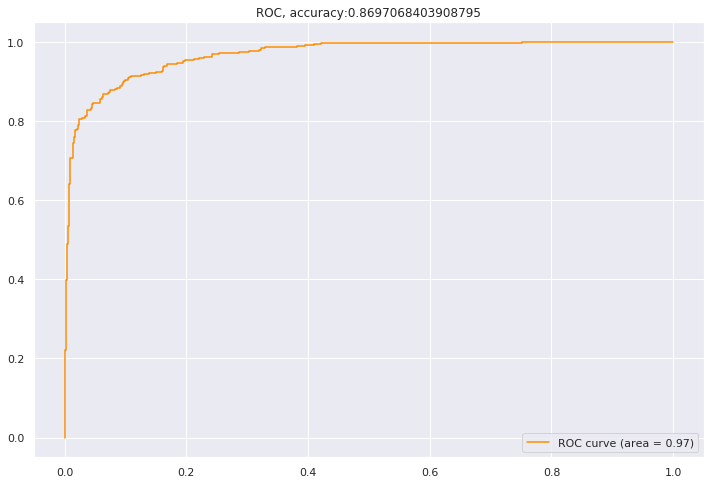

In [6]:
data=pd.read_csv("spam.csv")
features = data[data.columns.difference(['label'])]
target = data.label.values
mtry = int(np.round(np.sqrt(features.size/target.size)))
sampsize = int(np.round(0.632 * target.size))
train, test = train_test_split(data.values, test_size=0.2, random_state=42)
forest, chosen_features=create_random_forest(train, 20, mtry, sampsize, 3)
test_f=pd.DataFrame(test)
test_features=test_f[test_f.columns.difference([len(test[0])-1])].values
prob, classes=prediction(20, forest, test_features, chosen_features)
target_test=[]
for i in range(len(test)):
    target_test.append(test[i][len(test[i])-1])
target_test=np.array(target_test)
accuracy = accuracy_score(target_test, classes)
roc_auc, x, y=ROC_AUC(target_test, prob[:, 1]) 
plt.figure(figsize=(12, 8))
plt.plot(x, y, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.title(f'ROC, accuracy:{accuracy}')
plt.legend(loc="lower right")
plt.show()

**Cancer**

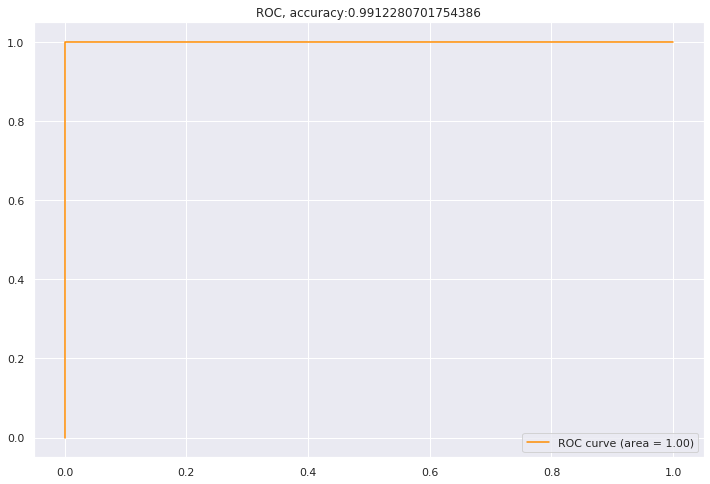

In [7]:
data=pd.read_csv("cancer.csv")
data['int_label'] = data.label.map({'M':1, 'B':0})
data['label'] = data.int_label
features = data[data.columns.difference(['label'])]
target = data.label.values
mtry = int(np.round(np.sqrt(features.size/target.size)))
sampsize = int(np.round(0.632 * target.size))
train, test = train_test_split(data.values, test_size=0.2, random_state=42)
forest, chosen_features=create_random_forest(train, 20, mtry, sampsize, 3)
test_f=pd.DataFrame(test)
test_features=test_f[test_f.columns.difference([len(test[0])-1])].values
prob, classes=prediction(20, forest, test_features, chosen_features)
target_test=[]
for i in range(len(test)):
    target_test.append(test[i][len(test[i])-1])
target_test=np.array(target_test)
accuracy = accuracy_score(target_test, classes)
roc_auc, x, y=ROC_AUC(target_test, prob[:, 1]) 
plt.figure(figsize=(12, 8))
plt.plot(x, y, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.title(f'ROC, accuracy:{accuracy}')
plt.legend(loc="lower right")
plt.show()

# Cross Validation

In [8]:
def evaluate_algorithm(dataset, ntrees, mtry, sampsize, max_depth):
    kf=KFold(n_splits=5, random_state=42, shuffle=False)
    score=0
    best_ntree=0
    best_depth=0
    best_x=[]
    best_y=[]
    for number in ntrees:
        for depth in max_depth:
            for train_index, test_index in kf.split(dataset):
                train, test = dataset[train_index], dataset[test_index]
                forest, chosen_features=create_random_forest(train, number, mtry, sampsize, depth)
                test_f=pd.DataFrame(test)
                test_features=test_f[test_f.columns.difference([len(test[0])-1])].values
                prob, classes=prediction(number, forest, test_features, chosen_features)
                target_test=[]
                for i in range(len(test)):
                    target_test.append(test[i][len(train[i])-1])
                target_test=np.array(target_test)
                roc_auc, x, y= ROC_AUC(target_test, prob[:, 1]) 
                if score<roc_auc:
                    best_ntree=number
                    best_depth=depth
                    score=roc_auc
                    best_x=x
                    best_y=y
                    accuracy = accuracy_score(target_test, classes)
    return best_ntree, best_depth, score, best_x, best_y, accuracy

**Spam**

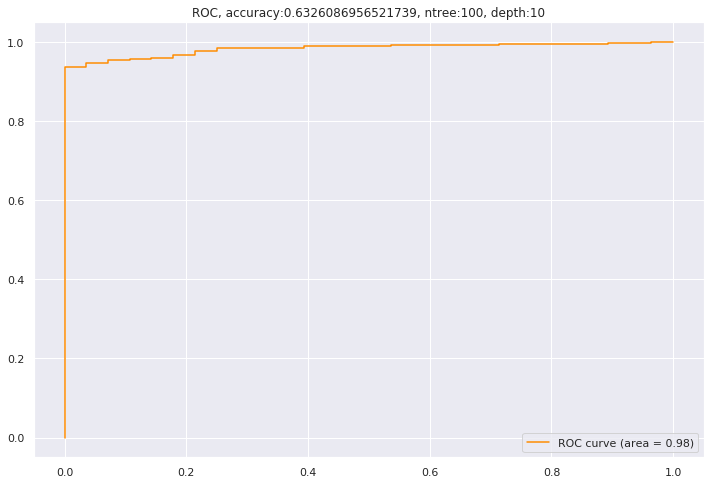

In [9]:
data=pd.read_csv("spam.csv")
features = data[data.columns.difference(['label'])]
target = data.label.values
mtry = int(np.round(np.sqrt(features.size/target.size)))
sampsize = int(np.round(0.632 * target.size))
ntree = [100, 50, 30, 20, 10, 5]
max_depth = [10, 7, 5, 3, 2]
best_ntree, best_depth, score, best_x, best_y,accuracy =evaluate_algorithm(data.values, ntree, mtry, sampsize, max_depth)
plt.figure(figsize=(12, 8))
plt.plot(best_x, best_y, color='darkorange', label='ROC curve (area = %0.2f)' % score)
plt.title(f'ROC, accuracy:{accuracy}, ntree:{best_ntree}, depth:{best_depth}')
plt.legend(loc="lower right")
plt.show()

**Cancer**

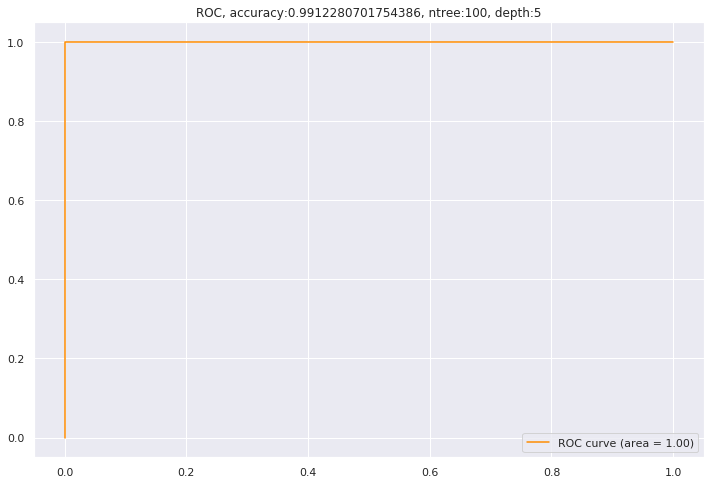

In [10]:
data=pd.read_csv("cancer.csv")
data['int_label'] = data.label.map({'M':1, 'B':0})
data['label'] = data.int_label
features = data[data.columns.difference(['label'])]
target = data.label.values
mtry = int(np.round(np.sqrt(features.size/target.size)))
sampsize = int(np.round(0.632 * target.size))
ntree = [100, 50, 30, 20, 10, 5]
max_depth = [10, 7, 5, 3, 2]
best_ntree, best_depth, score, best_x, best_y,accuracy =evaluate_algorithm(data.values, ntree, mtry, sampsize, max_depth)
plt.figure(figsize=(12, 8))
plt.plot(best_x, best_y, color='darkorange', label='ROC curve (area = %0.2f)' % score)
plt.title(f'ROC, accuracy:{accuracy}, ntree:{best_ntree}, depth:{best_depth}')
plt.legend(loc="lower right")
plt.show()